# Experiment description
## Hypothesis: 
Identified periodicity on agressive behavior phenomenon (experiment 1) is also observed considering other data subsets
## Method: 
Fourier analysis to identify periodicity on time series signals

Statistic mesaure to compare periodic values
## Time windows: 
- Year (by days) between 2017-2018
- Semester (by days) between 2017-2018
- Trimester (by days) between 2017-2018
- Month (by days) between 2017-2018
- Years (by months) between 2017-2018

## Built-in methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import calendar
import scipy as sp
import scipy.fftpack
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

In [2]:
def low_pass_filter(signal, fc =0.04, b =0.08):
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1
    n = np.arange(N)

    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)

    s = signal
    s = s - np.nanmean(s)
    filtered_signal = np.convolve(s, sinc_func)
    return filtered_signal

In [3]:
def fourier_analysis(signal):
    time = range(len(signal))
    fftdata = np.fft.fft(signal)
    fftdatafreq = np.zeros((len(signal)))

    for i in range(len(fftdata)):
        fftdatafreq[i] = abs(fftdata[i].real)

    plt.ylabel("Amplitude")
    plt.xlabel("Frequency")
    
    unilateral_fft = fftdatafreq[0:len(fftdatafreq) // 2]
    plt.plot(time[1:len(fftdatafreq) // 2], unilateral_fft[1:])
    return unilateral_fft

In [4]:
def get_max_frequencies(unilateral_fft_signal,fs_original_signal):
    max_freq = unilateral_fft_signal.argsort()[-10:][::-1]
    print('Max frequencies: ',max_freq)
    periodicity = fs_original_signal/max_freq
    print('Periods: ', periodicity)

## Data

In [5]:
data_location = '/Users/anamaria/Desktop/dev/security_project/datasets/verify_enrich_nuse_29112019.csv'
df_input = pd.read_csv(data_location,delimiter=",")

# Results
## Year (by days) analysis

In [7]:
df_input['date']=pd.to_datetime(df_input['FECHA'])
df_by_date = pd.DataFrame(df_input.groupby('date').size(),columns=["total_eventos"])

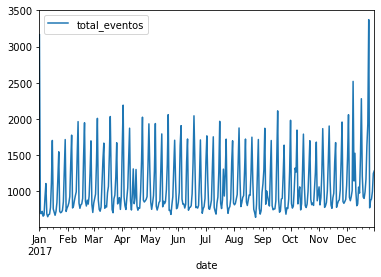

In [8]:
df_by_date.head(365).plot()

In [9]:
events_by_date = pd.Series(df_by_date['total_eventos']).values

In [202]:
events_by_date[364]

1284

In [199]:
events_by_date[729]

923

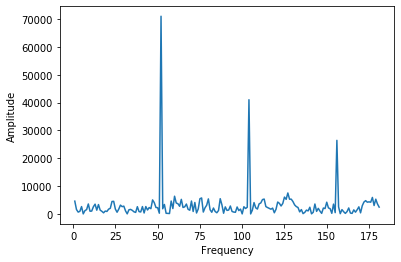

In [191]:
fft_events_in_year_2017 = fourier_analysis(events_by_date[0:364])

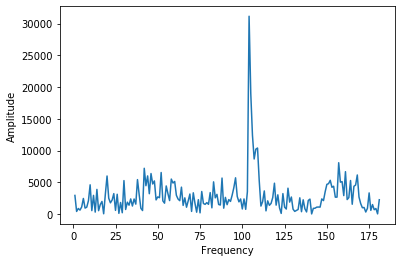

In [203]:
fft_events_in_year_2018 = fourier_analysis(events_by_date[365:730])

In [200]:
len(events_by_date[365:729])

364

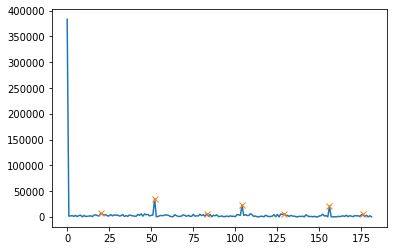

In [174]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(fft_events_in_year_2018, distance=20)
plt.plot(fft_events_in_year_2018)
plt.plot(peaks, fft_events_in_year_2018[peaks], "x")
plt.show()

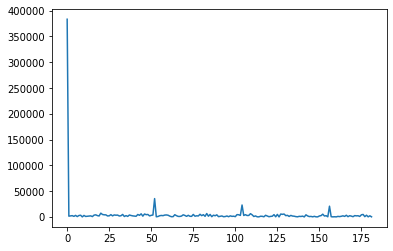

In [175]:
plt.plot(fft_events_in_year_2018)

In [176]:
peaks


array([ 20,  52,  83, 104, 129, 156, 176])

In [13]:
fs_2017=len(events_by_date[0:365])
get_max_frequencies(fft_events_in_year_2017,fs_2017)

Max frequencies:  [  0  52 104  47 151  48  89 155  43  50]
Periods:  [       inf 7.01923077 3.50961538 7.76595745 2.41721854 7.60416667
 4.1011236  2.35483871 8.48837209 7.3       ]


/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



In [48]:
fs_2017
len(events_by_date[0:365])

365

In [49]:
fs_2018=len(events_by_date[366:731])
get_max_frequencies(fft_events_in_year_2018,fs_2018)

Max frequencies:  [  0  52 104 156  20  83 109  44  46 129]
Periods:  [        inf  7.01923077  3.50961538  2.33974359 18.25        4.39759036
  3.34862385  8.29545455  7.93478261  2.82945736]


/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



In [198]:
df_by_date.iloc[[730]]

,total_eventos
date,
2019-01-01,2418


In [152]:
df_by_date_period = pd.DataFrame(df_input.groupby(['ANIO','PERIODO_TS','date']).size(),columns=["total_eventos"])
df_by_date_period.reset_index(inplace=True)

In [155]:
period_list = ['2018/01', '2018/02']
df_by_period=df_by_date_period[df_by_date_period.PERIODO_TS.isin(period_list)]
events_on_period = pd.Series(df_by_period['total_eventos']).values

In [156]:
events_on_period

array([2550,  611,  745,  728,  676,  870, 1106,  788,  617,  704,  696,
        821, 1117, 1264,  719,  676,  697,  770,  838, 1189, 1498,  732,
        724,  733,  811,  865, 1315, 1719,  816,  714,  880,  949,  897,
       1409, 2031,  867,  872, 1013,  980,  979, 1335, 1928,  822,  800,
        824,  823, 1079, 1425, 1777,  871,  863,  825,  856,  872, 1206,
       1559,  784,  758,  910])

In [117]:
def build_semester_list(year,semester=1):
    if semester == 1:
        month_list = ['01','02','03','04','05','06']
    if semester == 2:
        month_list = ['07','08','09','10','11','12']
    semester_list = map(lambda m: year+'/'+str(m), month_list)
    return (list(semester_list))

def build_trimester_list(year,trimester=1):
    if trimester == 1:
        month_list = ['01','02','03']
    if trimester == 2:
        month_list = ['04','05','06']
    if trimester == 3:
        month_list = ['07','08','09']
    if trimester == 4:
        month_list = ['10','11','12']
    trimester_list = map(lambda m: year+'/'+str(m), month_list)
    return (list(trimester_list))

2017
2018


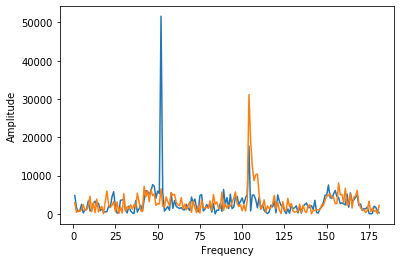

In [211]:
years=[['2017'],['2018']]
fft_events_in_subset = {}
events_on_period = {}
for year in years:
    print(year[0])
    df_by_period=df_by_date_period[df_by_date_period.ANIO.isin(year)]
    events_on_period[year[0]] = pd.Series(df_by_period['total_eventos']).values
    fft_events_in_subset[year[0]] = fourier_analysis(events_on_period[year[0]])
    

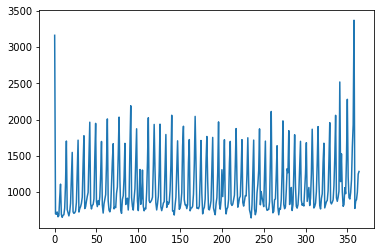

In [212]:
plt.plot(events_on_period['2017'])

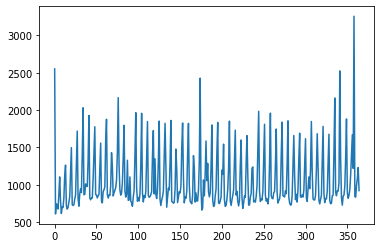

In [213]:
plt.plot(events_on_period['2018'])

## Semester (by days) analysis

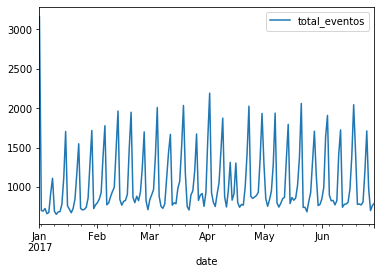

In [119]:
df_by_date.head(180).plot()

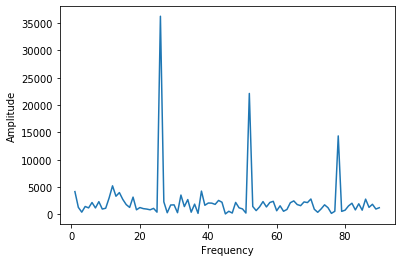

In [17]:
fft_events_in_semester_2017_1 = fourier_analysis(events_by_date[0:182])

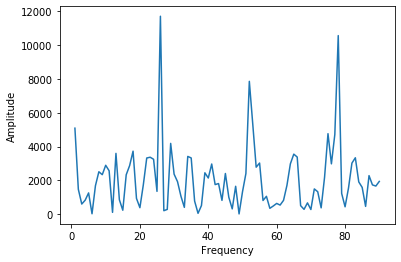

In [18]:
fft_events_in_semester_2017_2 = fourier_analysis(events_by_date[183:365])

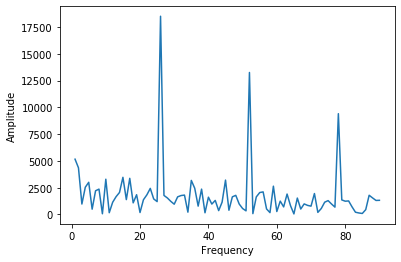

In [19]:
fft_events_in_semester_2018_1 = fourier_analysis(events_by_date[366:548])

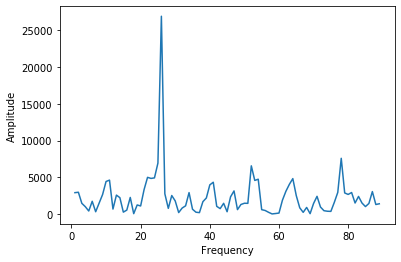

In [20]:
fft_events_in_semester_2018_2 = fourier_analysis(events_by_date[549:730])

In [21]:
fs_2017_1=len(events_by_date[0:182])
get_max_frequencies(fft_events_in_semester_2017_1,fs_2017_1)

Max frequencies:  [ 0 26 52 78 12 38  1 14 32 13]
Periods:  [         inf   7.           3.5          2.33333333  15.16666667
   4.78947368 182.          13.           5.6875      14.        ]


/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



In [22]:
fs_2017_2=len(events_by_date[183:365])
get_max_frequencies(fft_events_in_semester_2017_2,fs_2017_2)

Max frequencies:  [ 0 26 78 52 53  1 75 77 29 18]
Periods:  [         inf   7.           2.33333333   3.5          3.43396226
 182.           2.42666667   2.36363636   6.27586207  10.11111111]


/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



In [23]:
fs_2018_1=len(events_by_date[366:548])
get_max_frequencies(fft_events_in_semester_2018_1,fs_2018_1)

Max frequencies:  [ 0 26 52 78  1  2 15 17 10 45]
Periods:  [         inf   7.           3.5          2.33333333 182.
  91.          12.13333333  10.70588235  18.2          4.04444444]


/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



In [24]:
fs_2018_2=len(events_by_date[549:730])
get_max_frequencies(fft_events_in_semester_2018_2,fs_2018_2)

Max frequencies:  [ 0 26 78 25 52 22 24 23 64 54]
Periods:  [       inf 6.96153846 2.32051282 7.24       3.48076923 8.22727273
 7.54166667 7.86956522 2.828125   3.35185185]


/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



## Trimester (by days) analysis

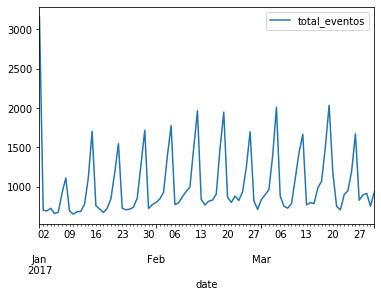

In [128]:
df_by_date.head(90).plot()

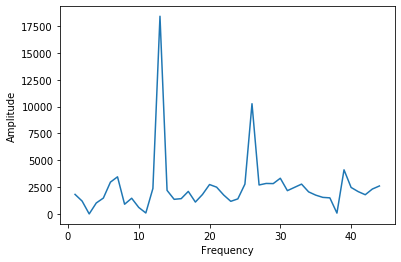

In [52]:
fft_events_in_trimester = fourier_analysis(events_by_date[0:90])

In [53]:
fs=len(events_by_date[0:90])
get_max_frequencies(fft_events_in_trimester,fs)

Max frequencies:  [ 0 13 26 39  7 30  6 28 29 25]
Periods:  [        inf  6.92307692  3.46153846  2.30769231 12.85714286  3.
 15.          3.21428571  3.10344828  3.6       ]


/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



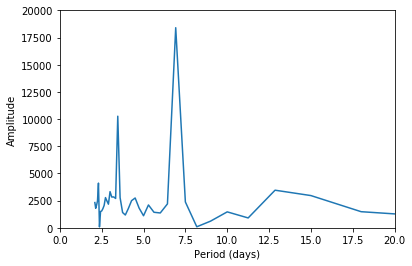

In [54]:
plt.ylabel("Amplitude")
plt.xlabel("Period (days)")
points_x = np.arange(len(fft_events_in_trimester))[::-1]
period = fs/points_x
y=fft_events_in_trimester[::-1]
plt.axis([0, 20, 0, 20000])
plt.plot(period[1:], y[1:])

## Month (by days) analysis

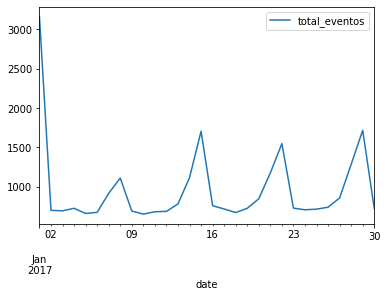

In [150]:
df_by_date.head(30).plot()

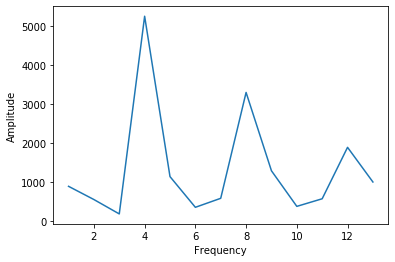

In [55]:
fft_events_in_month = fourier_analysis(events_by_date[31:60])

In [56]:
fs=len(events_by_date[31:60])
get_max_frequencies(fft_events_in_month,fs)

Max frequencies:  [ 0  4  8 12  9  5 13  1  7 11]
Periods:  [        inf  7.25        3.625       2.41666667  3.22222222  5.8
  2.23076923 29.          4.14285714  2.63636364]


/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



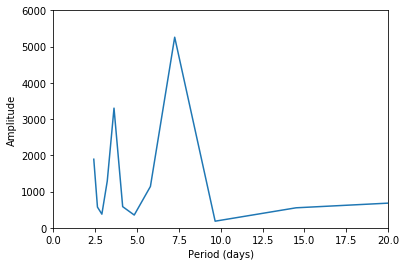

In [57]:
plt.ylabel("Amplitude")
plt.xlabel("Period (days)")
points_x = np.arange(len(fft_events_in_month))[::-1]
period = fs/points_x
y=fft_events_in_month[::-1]
plt.axis([0, 20, 0, 6000])
plt.plot(period[1:], y[1:])

## Years (by months) analysis

In [59]:
df_by_month = pd.DataFrame(df_input.groupby('PERIODO_TS').size(),columns=["total_eventos"])

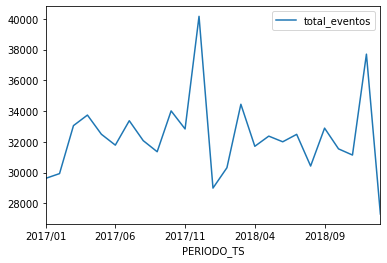

In [156]:
df_by_month.plot()

In [60]:
events_by_month = pd.Series(df_by_month['total_eventos']).values[:24]

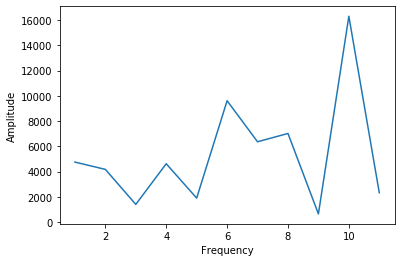

In [61]:
fft_events_in_year = fourier_analysis(events_by_month)

In [62]:
fs=len(events_by_month)
get_max_frequencies(fft_events_in_year,fs)

Max frequencies:  [ 0 10  6  8  7  1  4  2 11  5]
Periods:  [        inf  2.4         4.          3.          3.42857143 24.
  6.         12.          2.18181818  4.8       ]


/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



## Week (by hour, minutes)

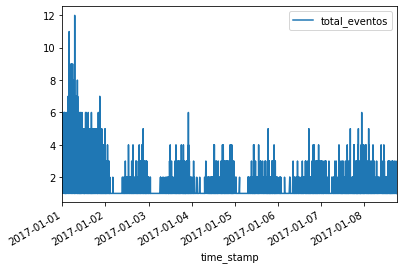

In [257]:
df_by_cdate.head(5000).plot()

In [264]:
one_week = pd.Series(df_by_cdate['total_eventos']).values[5000:10000]

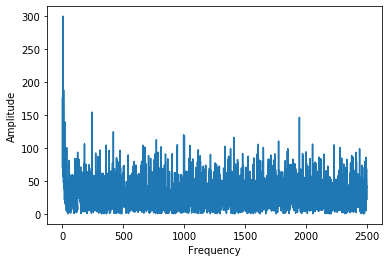

In [265]:
fft_events_in_week = fourier_analysis(one_week)

In [266]:
fs=len(one_week)
get_max_frequencies(fft_events_in_week,fs)

Max frequencies:  [   0    7   11    2  243    6    5 1946   20   12]
Periods:  [          inf  714.28571429  454.54545455 2500.           20.57613169
  833.33333333 1000.            2.56937307  250.          416.66666667]


/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



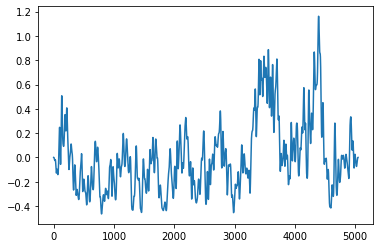

In [267]:
#Preprocess signal LPF
filtered = low_pass_filter(one_week, fc =0.01, b =0.08)
plt.plot(filtered)

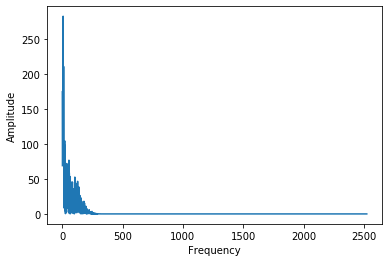

In [268]:
fft_events_in_week = fourier_analysis(filtered)

In [269]:
fs=len(filtered)
get_max_frequencies(fft_events_in_week,fs)

Max frequencies:  [ 7 11  2  6  5 12 20  9 17 19]
Periods:  [ 721.42857143  459.09090909 2525.          841.66666667 1010.
  420.83333333  252.5         561.11111111  297.05882353  265.78947368]
